In [40]:
# Python Imports
import numpy as np
import pandas as pd
import seaborn as sn

# Scikit-Learn Imports
from sklearn.metrics import f1_score

# PyTorch Imports
import torch

# Transformer Imports
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Importing Financial Sentiment Analysis Data

Data Source: [Kaggle Financial Sentiement Analysis](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis)

In [2]:
df = pd.read_csv('./Data/FinancialSentimentAnalysis.csv')

In [3]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


# Plotting Spread of Sentiment

<Axes: >

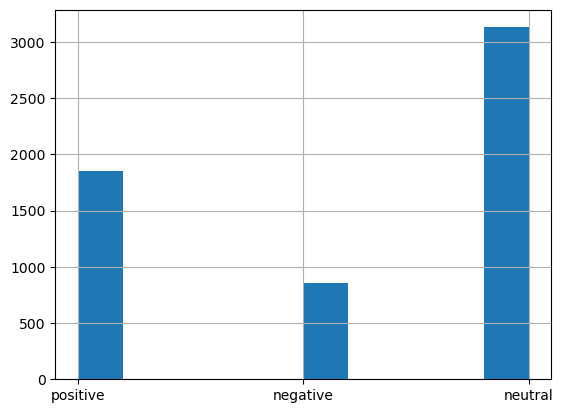

In [4]:
df['Sentiment'].hist()

# Mapping Labels to Numerical Values

In [5]:
target_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Target'] = df['Sentiment'].map(target_map)

# Saving Numerically Mapped Data to CSV to Load with Hugging Face

In [6]:
df_ = df[['Sentence', 'Target']]
df_.columns = [['sentence', 'label']]
df_.to_csv('./Data/MappedFinancialSentiment.csv', index=None)

# Loading Data with Hugging Face Data Loader

In [7]:
dataset = load_dataset('csv', data_files='./Data/MappedFinancialSentiment.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
# Previewing Dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 5842
    })
})

# Creating Data Split

In [9]:
split = dataset['train'].train_test_split(test_size=0.4)

In [46]:
split['test'].to_csv('./Data/TestingData.csv', index=None)

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

284144

# Loading Checkpoints for Each BERT Model

In [10]:
checkpoint_distilbert = 'distilbert-base-cased'
checkpoint_bert = 'distilbert-base-cased'
checkpoint_largebert = 'bert-large-cased'

# Loading Tokenizer for Each BERT Model

In [11]:
tokenizer_distilbert = AutoTokenizer.from_pretrained(checkpoint_distilbert)
tokenizer_bert = AutoTokenizer.from_pretrained(checkpoint_bert)
tokenizer_largebert = AutoTokenizer.from_pretrained(checkpoint_largebert)

# Creating Tokenization Functions

In [12]:
def tokenize_distilbert_fn(batch):
  return tokenizer_distilbert(batch['sentence'], truncation=True)

def tokenize_bert_fn(batch):
  return tokenizer_bert(batch['sentence'], truncation=True)

def tokenize_largebert_fn(batch):
  return tokenizer_bert(batch['sentence'], truncation=True)

In [13]:
tokenized_datasets_distilbert = split.map(tokenize_distilbert_fn, batched=True)
tokenized_datasets_bert = split.map(tokenize_bert_fn, batched=True)
tokenized_datasets_largebert = split.map(tokenize_largebert_fn, batched=True)

Map:   0%|          | 0/3505 [00:00<?, ? examples/s]

Map:   0%|          | 0/2337 [00:00<?, ? examples/s]

Map:   0%|          | 0/3505 [00:00<?, ? examples/s]

Map:   0%|          | 0/2337 [00:00<?, ? examples/s]

Map:   0%|          | 0/3505 [00:00<?, ? examples/s]

Map:   0%|          | 0/2337 [00:00<?, ? examples/s]

# Instantiating Base BERT Models
 This takes the pretrained BERT model and removes the final layer to be replaced with the number of output layer neurons specified by the user

In [14]:
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_distilbert, num_labels=3)

model_bert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_bert, num_labels=3)

model_largebert = AutoModelForSequenceClassification.from_pretrained(
    checkpoint_largebert, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Creating Method for Computing Metrics

In [15]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

# Creating Training Arguments

In [16]:
training_args_distilbert = TrainingArguments(
  output_dir='./Models/distil_bert_training',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=10,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  logging_steps=150, # otherwise, 'no log' will appear under training loss
)

training_args_bert = TrainingArguments(
  output_dir='./Models/bert_training',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=10,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  logging_steps=150, # otherwise, 'no log' will appear under training loss
)

training_args_largebert = TrainingArguments(
  output_dir='./Models/large_bert_training',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=10,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
  logging_steps=150, # otherwise, 'no log' will appear under training loss
)

# Creating Trainer Objects

In [17]:
trainer_distilbert = Trainer(
    model_distilbert,
    training_args_distilbert,
    train_dataset=tokenized_datasets_distilbert["train"],
    eval_dataset=tokenized_datasets_distilbert["test"],
    tokenizer=tokenizer_distilbert,
    compute_metrics=compute_metrics,
)

trainer_bert = Trainer(
    model_bert,
    training_args_bert,
    train_dataset=tokenized_datasets_bert["train"],
    eval_dataset=tokenized_datasets_bert["test"],
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
)

trainer_largebert = Trainer(
    model_largebert,
    training_args_largebert,
    train_dataset=tokenized_datasets_largebert["train"],
    eval_dataset=tokenized_datasets_largebert["test"],
    tokenizer=tokenizer_largebert,
    compute_metrics=compute_metrics,
)

c:\Users\zjshe\anaconda3\envs\pytorch-gpu\lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


# Training and Saving Models

In [18]:
trainer_distilbert.train()

  0%|          | 0/2200 [00:00<?, ?it/s]

{'loss': 0.7135, 'learning_rate': 4.659090909090909e-05, 'epoch': 0.68}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.5067263245582581, 'eval_accuracy': 0.7774925117672229, 'eval_f1': 0.643538793100549, 'eval_runtime': 0.6829, 'eval_samples_per_second': 3421.922, 'eval_steps_per_second': 54.177, 'epoch': 1.0}
{'loss': 0.4426, 'learning_rate': 4.318181818181819e-05, 'epoch': 1.36}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.4865158498287201, 'eval_accuracy': 0.7796320068463842, 'eval_f1': 0.7384166450236113, 'eval_runtime': 0.6791, 'eval_samples_per_second': 3441.195, 'eval_steps_per_second': 54.482, 'epoch': 2.0}
{'loss': 0.3712, 'learning_rate': 3.9772727272727275e-05, 'epoch': 2.05}
{'loss': 0.2649, 'learning_rate': 3.6363636363636364e-05, 'epoch': 2.73}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.6214855909347534, 'eval_accuracy': 0.8014548566538297, 'eval_f1': 0.6944103762549149, 'eval_runtime': 0.6816, 'eval_samples_per_second': 3428.669, 'eval_steps_per_second': 54.284, 'epoch': 3.0}
{'loss': 0.2023, 'learning_rate': 3.295454545454545e-05, 'epoch': 3.41}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.7551543712615967, 'eval_accuracy': 0.7650834403080873, 'eval_f1': 0.7025593870538073, 'eval_runtime': 0.6731, 'eval_samples_per_second': 3471.864, 'eval_steps_per_second': 54.967, 'epoch': 4.0}
{'loss': 0.2022, 'learning_rate': 2.954545454545455e-05, 'epoch': 4.09}
{'loss': 0.1614, 'learning_rate': 2.6136363636363637e-05, 'epoch': 4.77}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9140689969062805, 'eval_accuracy': 0.7685066324347454, 'eval_f1': 0.7052717340318152, 'eval_runtime': 0.6874, 'eval_samples_per_second': 3399.531, 'eval_steps_per_second': 53.822, 'epoch': 5.0}
{'loss': 0.1405, 'learning_rate': 2.272727272727273e-05, 'epoch': 5.45}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9310536980628967, 'eval_accuracy': 0.764655541292255, 'eval_f1': 0.7039866345862845, 'eval_runtime': 0.6877, 'eval_samples_per_second': 3398.397, 'eval_steps_per_second': 53.804, 'epoch': 6.0}
{'loss': 0.142, 'learning_rate': 1.9318181818181818e-05, 'epoch': 6.14}
{'loss': 0.1488, 'learning_rate': 1.590909090909091e-05, 'epoch': 6.82}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.0028270483016968, 'eval_accuracy': 0.7603765511339324, 'eval_f1': 0.6816127476252851, 'eval_runtime': 0.6813, 'eval_samples_per_second': 3430.249, 'eval_steps_per_second': 54.309, 'epoch': 7.0}
{'loss': 0.1198, 'learning_rate': 1.25e-05, 'epoch': 7.5}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.0544263124465942, 'eval_accuracy': 0.7599486521181001, 'eval_f1': 0.6800547470285939, 'eval_runtime': 0.6821, 'eval_samples_per_second': 3426.094, 'eval_steps_per_second': 54.243, 'epoch': 8.0}
{'loss': 0.1117, 'learning_rate': 9.090909090909091e-06, 'epoch': 8.18}
{'loss': 0.1158, 'learning_rate': 5.681818181818182e-06, 'epoch': 8.86}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.1105910539627075, 'eval_accuracy': 0.7620881471972615, 'eval_f1': 0.6781706846101415, 'eval_runtime': 0.6702, 'eval_samples_per_second': 3487.193, 'eval_steps_per_second': 55.21, 'epoch': 9.0}
{'loss': 0.0951, 'learning_rate': 2.2727272727272728e-06, 'epoch': 9.55}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.1875377893447876, 'eval_accuracy': 0.7595207531022679, 'eval_f1': 0.6781241395996159, 'eval_runtime': 0.676, 'eval_samples_per_second': 3457.263, 'eval_steps_per_second': 54.736, 'epoch': 10.0}
{'train_runtime': 59.4073, 'train_samples_per_second': 589.995, 'train_steps_per_second': 37.032, 'train_loss': 0.22632480491291393, 'epoch': 10.0}


TrainOutput(global_step=2200, training_loss=0.22632480491291393, metrics={'train_runtime': 59.4073, 'train_samples_per_second': 589.995, 'train_steps_per_second': 37.032, 'train_loss': 0.22632480491291393, 'epoch': 10.0})

In [19]:
trainer_distilbert.save_model('distilBERT')

In [20]:
# Clearing Cache Manually to Help with Memory Management
torch.cuda.empty_cache()

In [22]:
trainer_bert.train()

  0%|          | 0/2200 [00:00<?, ?it/s]

{'loss': 0.3552, 'learning_rate': 4.659090909090909e-05, 'epoch': 0.68}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.514566957950592, 'eval_accuracy': 0.79204107830552, 'eval_f1': 0.672373606519948, 'eval_runtime': 0.7012, 'eval_samples_per_second': 3332.904, 'eval_steps_per_second': 52.767, 'epoch': 1.0}
{'loss': 0.3257, 'learning_rate': 4.318181818181819e-05, 'epoch': 1.36}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.7461713552474976, 'eval_accuracy': 0.7680787334189131, 'eval_f1': 0.6953377774055362, 'eval_runtime': 0.6829, 'eval_samples_per_second': 3422.023, 'eval_steps_per_second': 54.178, 'epoch': 2.0}
{'loss': 0.2828, 'learning_rate': 3.9772727272727275e-05, 'epoch': 2.05}
{'loss': 0.2029, 'learning_rate': 3.6363636363636364e-05, 'epoch': 2.73}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.8606283664703369, 'eval_accuracy': 0.766367137355584, 'eval_f1': 0.6941133709909773, 'eval_runtime': 0.6751, 'eval_samples_per_second': 3461.655, 'eval_steps_per_second': 54.806, 'epoch': 3.0}
{'loss': 0.1764, 'learning_rate': 3.295454545454545e-05, 'epoch': 3.41}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9487983584403992, 'eval_accuracy': 0.7757809157038938, 'eval_f1': 0.7241242684076822, 'eval_runtime': 0.6672, 'eval_samples_per_second': 3502.864, 'eval_steps_per_second': 55.458, 'epoch': 4.0}
{'loss': 0.1655, 'learning_rate': 2.954545454545455e-05, 'epoch': 4.09}
{'loss': 0.14, 'learning_rate': 2.6136363636363637e-05, 'epoch': 4.77}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.0000722408294678, 'eval_accuracy': 0.7685066324347454, 'eval_f1': 0.7090218616455181, 'eval_runtime': 0.6819, 'eval_samples_per_second': 3427.402, 'eval_steps_per_second': 54.264, 'epoch': 5.0}
{'loss': 0.1541, 'learning_rate': 2.272727272727273e-05, 'epoch': 5.45}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9620106816291809, 'eval_accuracy': 0.7911852802738554, 'eval_f1': 0.6789771477236025, 'eval_runtime': 0.6723, 'eval_samples_per_second': 3476.304, 'eval_steps_per_second': 55.038, 'epoch': 6.0}
{'loss': 0.1322, 'learning_rate': 1.9318181818181818e-05, 'epoch': 6.14}
{'loss': 0.1342, 'learning_rate': 1.590909090909091e-05, 'epoch': 6.82}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.0840208530426025, 'eval_accuracy': 0.7599486521181001, 'eval_f1': 0.6961205950753339, 'eval_runtime': 0.674, 'eval_samples_per_second': 3467.598, 'eval_steps_per_second': 54.9, 'epoch': 7.0}
{'loss': 0.114, 'learning_rate': 1.25e-05, 'epoch': 7.5}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.1910851001739502, 'eval_accuracy': 0.7650834403080873, 'eval_f1': 0.6976080966907959, 'eval_runtime': 0.6888, 'eval_samples_per_second': 3392.915, 'eval_steps_per_second': 53.718, 'epoch': 8.0}
{'loss': 0.1131, 'learning_rate': 9.090909090909091e-06, 'epoch': 8.18}
{'loss': 0.108, 'learning_rate': 5.681818181818182e-06, 'epoch': 8.86}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.2384312152862549, 'eval_accuracy': 0.764655541292255, 'eval_f1': 0.6725027006879077, 'eval_runtime': 0.6996, 'eval_samples_per_second': 3340.354, 'eval_steps_per_second': 52.885, 'epoch': 9.0}
{'loss': 0.0968, 'learning_rate': 2.2727272727272728e-06, 'epoch': 9.55}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.2909374237060547, 'eval_accuracy': 0.762943945228926, 'eval_f1': 0.6763763202465637, 'eval_runtime': 0.7065, 'eval_samples_per_second': 3307.729, 'eval_steps_per_second': 52.369, 'epoch': 10.0}
{'train_runtime': 58.8355, 'train_samples_per_second': 595.728, 'train_steps_per_second': 37.392, 'train_loss': 0.17466052228754217, 'epoch': 10.0}


TrainOutput(global_step=2200, training_loss=0.17466052228754217, metrics={'train_runtime': 58.8355, 'train_samples_per_second': 595.728, 'train_steps_per_second': 37.392, 'train_loss': 0.17466052228754217, 'epoch': 10.0})

In [23]:
trainer_bert.save_model('BERTModel')

In [24]:
# Clearing Cache Manually to Help with Memory Management
torch.cuda.empty_cache()

In [25]:
trainer_largebert.train()

  0%|          | 0/2200 [00:00<?, ?it/s]

{'loss': 1.0134, 'learning_rate': 4.659090909090909e-05, 'epoch': 0.68}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 1.0030232667922974, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6625, 'eval_samples_per_second': 638.084, 'eval_steps_per_second': 10.102, 'epoch': 1.0}
{'loss': 0.9883, 'learning_rate': 4.318181818181819e-05, 'epoch': 1.36}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.990476131439209, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6648, 'eval_samples_per_second': 637.696, 'eval_steps_per_second': 10.096, 'epoch': 2.0}
{'loss': 1.0091, 'learning_rate': 3.9772727272727275e-05, 'epoch': 2.05}
{'loss': 1.0006, 'learning_rate': 3.6363636363636364e-05, 'epoch': 2.73}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9843916893005371, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.4656, 'eval_samples_per_second': 674.335, 'eval_steps_per_second': 10.676, 'epoch': 3.0}
{'loss': 1.0031, 'learning_rate': 3.295454545454545e-05, 'epoch': 3.41}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9808838963508606, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6832, 'eval_samples_per_second': 634.503, 'eval_steps_per_second': 10.046, 'epoch': 4.0}
{'loss': 1.0096, 'learning_rate': 2.954545454545455e-05, 'epoch': 4.09}
{'loss': 0.996, 'learning_rate': 2.6136363636363637e-05, 'epoch': 4.77}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9787450432777405, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6871, 'eval_samples_per_second': 633.826, 'eval_steps_per_second': 10.035, 'epoch': 5.0}
{'loss': 1.0087, 'learning_rate': 2.272727272727273e-05, 'epoch': 5.45}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9790253043174744, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6788, 'eval_samples_per_second': 635.269, 'eval_steps_per_second': 10.058, 'epoch': 6.0}
{'loss': 0.9904, 'learning_rate': 1.9318181818181818e-05, 'epoch': 6.14}
{'loss': 1.0025, 'learning_rate': 1.590909090909091e-05, 'epoch': 6.82}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9811078906059265, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6468, 'eval_samples_per_second': 640.842, 'eval_steps_per_second': 10.146, 'epoch': 7.0}
{'loss': 0.9862, 'learning_rate': 1.25e-05, 'epoch': 7.5}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9794172048568726, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6818, 'eval_samples_per_second': 634.739, 'eval_steps_per_second': 10.049, 'epoch': 8.0}
{'loss': 0.994, 'learning_rate': 9.090909090909091e-06, 'epoch': 8.18}
{'loss': 0.9959, 'learning_rate': 5.681818181818182e-06, 'epoch': 8.86}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9801177382469177, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6749, 'eval_samples_per_second': 635.937, 'eval_steps_per_second': 10.068, 'epoch': 9.0}
{'loss': 0.9756, 'learning_rate': 2.2727272727272728e-06, 'epoch': 9.55}


  0%|          | 0/37 [00:00<?, ?it/s]

{'eval_loss': 0.9787930846214294, 'eval_accuracy': 0.5387248609328199, 'eval_f1': 0.23340748980348536, 'eval_runtime': 3.6903, 'eval_samples_per_second': 633.277, 'eval_steps_per_second': 10.026, 'epoch': 10.0}
{'train_runtime': 273.1699, 'train_samples_per_second': 128.308, 'train_steps_per_second': 8.054, 'train_loss': 0.9983211690729314, 'epoch': 10.0}


TrainOutput(global_step=2200, training_loss=0.9983211690729314, metrics={'train_runtime': 273.1699, 'train_samples_per_second': 128.308, 'train_steps_per_second': 8.054, 'train_loss': 0.9983211690729314, 'epoch': 10.0})

In [26]:
trainer_largebert.save_model('LargeBERT')

In [27]:
# Clearing Cache Manually to Help with Memory Management
torch.cuda.empty_cache()